In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import plotly.express as px
import plotly.figure_factory as ff
import numpy as np

In [2]:
# Read csv files
finals_csv = pd.read_csv("UCL_Finals_1955-2023.csv", sep=",", encoding="utf-8")
perf_csv = pd.read_csv("UCL_AllTime_Performance_Table.csv", sep=",", encoding="utf-8")

<Figure size 1400x700 with 0 Axes>

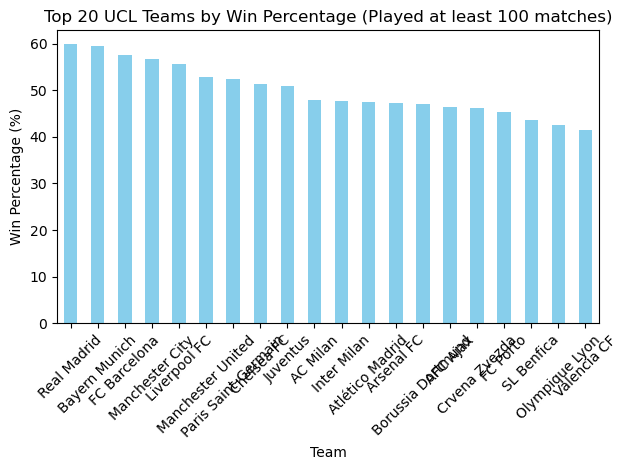

Correlation between Win Percentage and Number of Titles: 0.66


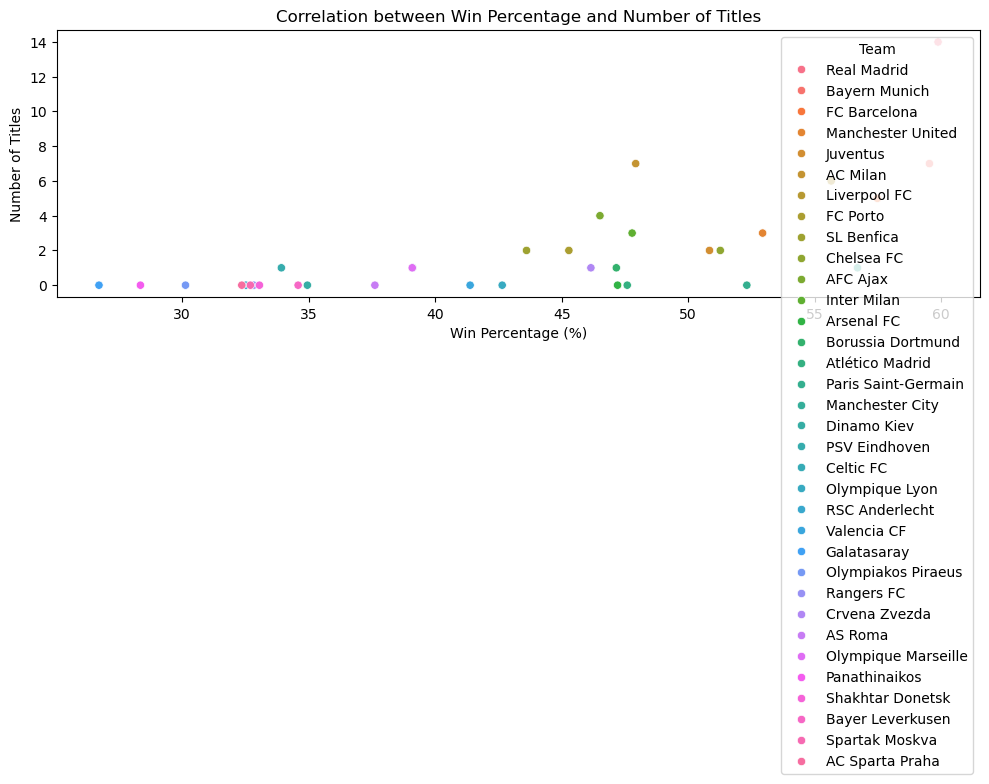

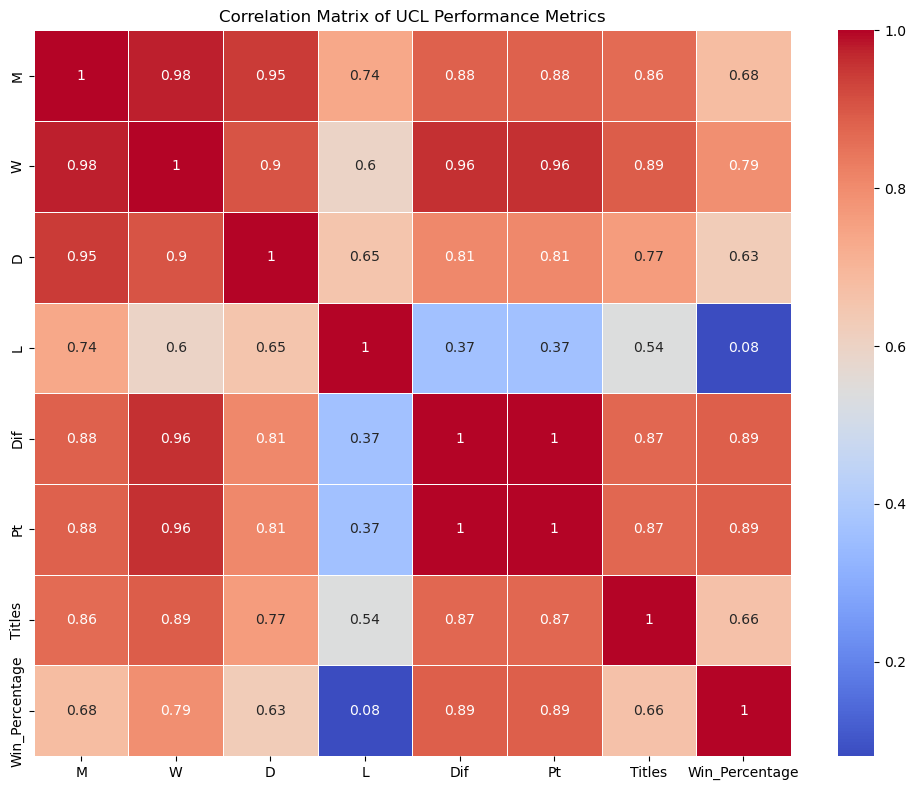

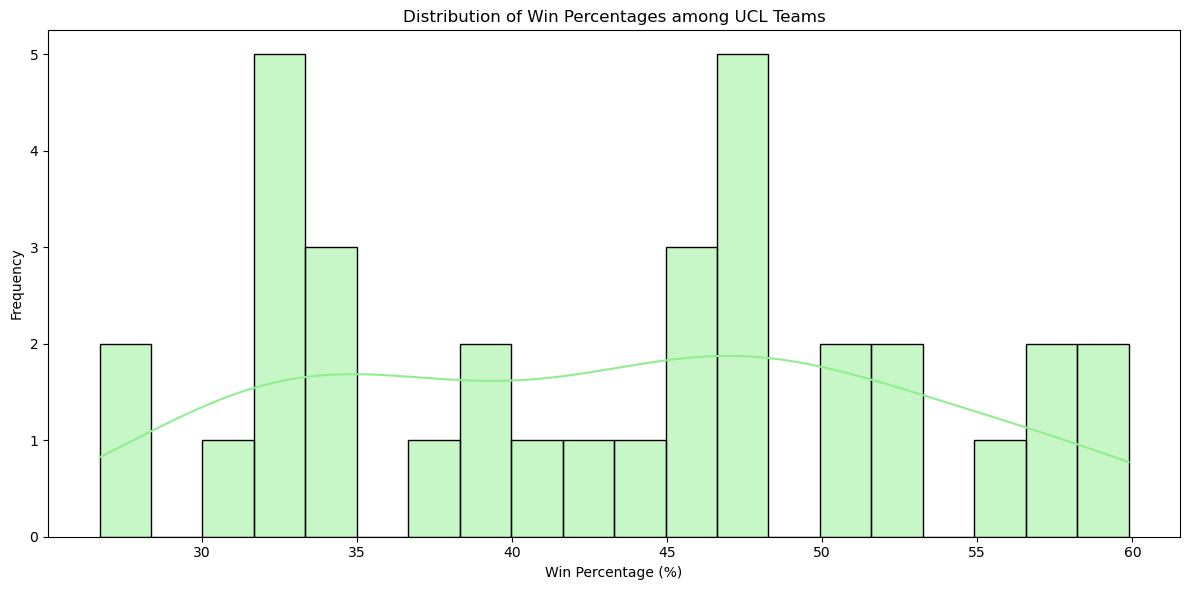

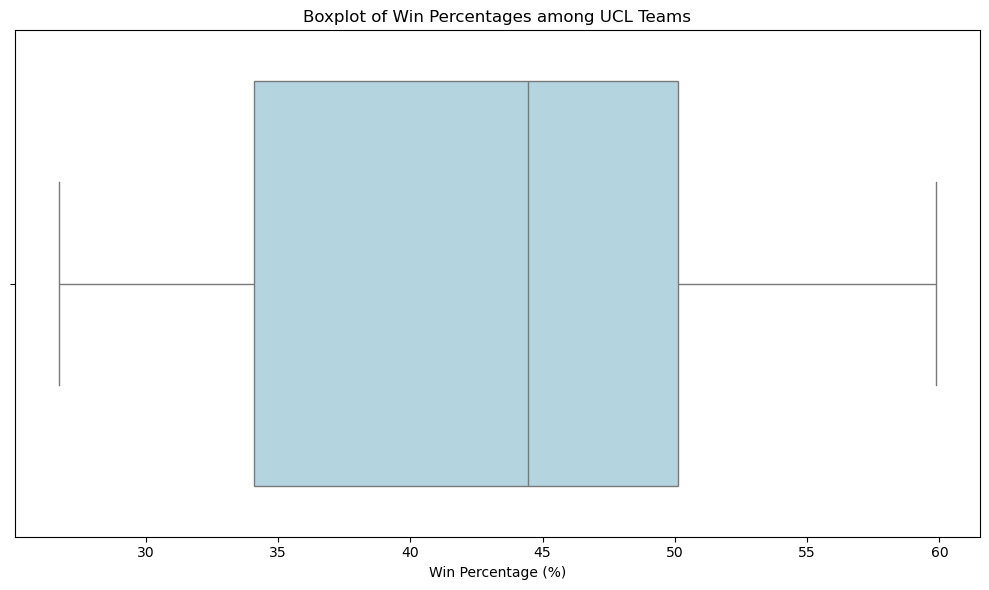

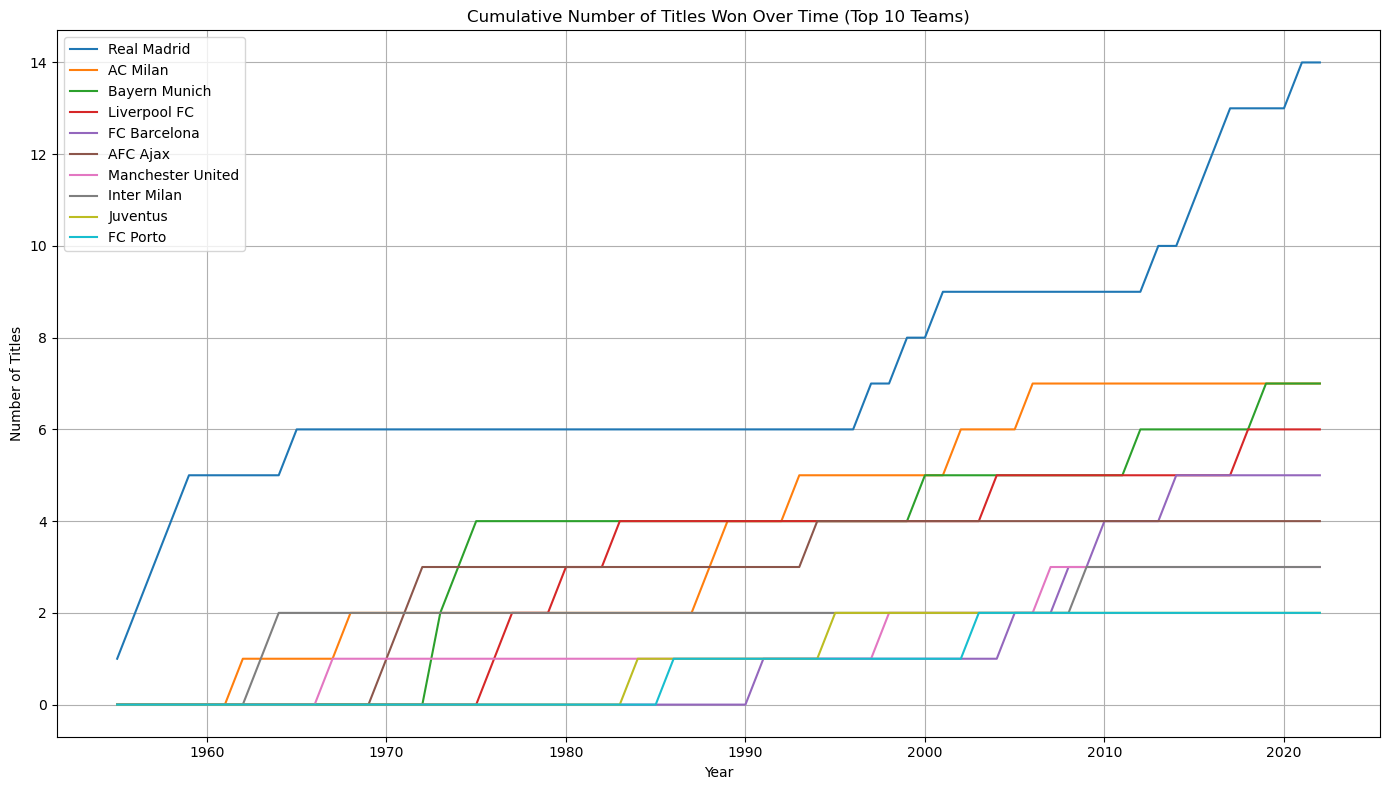

,#,Team,M,W,D,L,goals,Dif,Pt,Titles,Win_Percentage
0,1.0,Real Madrid,486,291,85,110,1076:55:00,533,533,14,59.876543
1,2.0,Bayern Munich,388,231,78,79,817:24:00,427,427,7,59.536082
2,3.0,FC Barcelona,341,196,77,68,675:51:00,319,319,5,57.478006
3,4.0,Manchester United,289,153,69,67,524:56:00,224,224,3,52.941176
4,5.0,Juventus,297,151,68,78,472:57:00,171,171,2,50.841751


In [5]:

# Load the data
ucl_finals = pd.DataFrame(data=finals_csv)
ucl_performance = pd.DataFrame(data=perf_csv)

# Count the number of times each team has won from the UCL Finals data
titles_count = ucl_finals['Winners'].value_counts().reset_index()
titles_count.columns = ['Team', 'Titles']

# Merge the titles count with the UCL performance table
ucl_performance_with_titles = pd.merge(ucl_performance, titles_count, how='left', on='Team')

# Fill NaN titles with 0 (indicating no titles)
ucl_performance_with_titles['Titles'] = ucl_performance_with_titles['Titles'].fillna(0).astype(int)

# Calculate the win percentage
ucl_performance_with_titles['Win_Percentage'] = (ucl_performance_with_titles['W'] / ucl_performance_with_titles['M']) * 100

# Filter teams that have played at least 100 matches
ucl_performance_with_titles = ucl_performance_with_titles[ucl_performance_with_titles['M'] >= 100]

# Display the updated table
#import ace_tools as tools; tools.display_dataframe_to_user(name="UCL All-Time Performance Table with Titles and Win Percentage", dataframe=ucl_performance_with_titles)

plt.figure(figsize=(14, 7))
top_teams = ucl_performance_with_titles.sort_values(by='Win_Percentage', ascending=False).head(20)
top_teams.plot(
    kind='bar', x='Team', y='Win_Percentage', legend=False, color='skyblue')
plt.title('Top 20 UCL Teams by Win Percentage (Played at least 100 matches)')
plt.xlabel('Team')
plt.ylabel('Win Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze correlation between win percentage and number of titles
correlation = ucl_performance_with_titles['Win_Percentage'].corr(ucl_performance_with_titles['Titles'])
print(f"Correlation between Win Percentage and Number of Titles: {correlation:.2f}")

# Scatter plot for visual correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ucl_performance_with_titles, x='Win_Percentage', y='Titles', hue='Team')
plt.title('Correlation between Win Percentage and Number of Titles')
plt.xlabel('Win Percentage (%)')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()

# Correlation matrix plot
plt.figure(figsize=(10, 8))
corr_matrix = ucl_performance_with_titles[['M', 'W', 'D', 'L', 'Dif', 'Pt', 'Titles', 'Win_Percentage']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of UCL Performance Metrics')
plt.tight_layout()
plt.show()

# Histogram of win percentages
plt.figure(figsize=(12, 6))
sns.histplot(ucl_performance_with_titles['Win_Percentage'], kde=True, bins=20, color='lightgreen')
plt.title('Distribution of Win Percentages among UCL Teams')
plt.xlabel('Win Percentage (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot for win percentages
plt.figure(figsize=(10, 6))
sns.boxplot(x=ucl_performance_with_titles['Win_Percentage'], color='lightblue')
plt.title('Boxplot of Win Percentages among UCL Teams')
plt.xlabel('Win Percentage (%)')
plt.tight_layout()
plt.show()

# Prepare data for titles won over time by top teams
ucl_finals['Year'] = ucl_finals['Season'].str.extract(r'(\d{4})').astype(int)

# Calculate cumulative titles won by each team over time
titles_over_time = ucl_finals.groupby(['Year', 'Winners']).size().unstack(fill_value=0).cumsum()

# Select top teams based on total number of titles
top_teams = ucl_performance_with_titles.sort_values(by='Titles', ascending=False).head(10)['Team']
titles_over_time_top = titles_over_time[top_teams]

# Plot the cumulative titles over time for top teams
plt.figure(figsize=(14, 8))
for team in titles_over_time_top.columns:
    plt.plot(titles_over_time_top.index, titles_over_time_top[team], label=team)

plt.title('Cumulative Number of Titles Won Over Time (Top 10 Teams)')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

ucl_performance_with_titles.head()


In [8]:
# Generate predictive model for match outcomes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare dataset for modeling (using basic features)
ucl_performance_with_titles['Win_Label'] = np.where(
    ucl_performance_with_titles['Win_Percentage'] > 50, 1, 0)  # Label: 1 for >50% win rate, 0 otherwise

# Feature selection
features = ucl_performance_with_titles[['M', 'W', 'D', 'L', 'Dif', 'Pt']]
labels = ucl_performance_with_titles['Win_Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.33      0.50         3

    accuracy                           0.82        11
   macro avg       0.90      0.67      0.69        11
weighted avg       0.85      0.82      0.78        11

